In [2]:
import os
os.environ['MNE_DATASETS_wang2016_PATH'] = 'E:/dataset/'

In [3]:
import matplotlib.pyplot as plt
import mne
import numpy as np
from scipy.stats import ttest_rel
import scipy.io
from mne.channels import make_standard_montage
from mne import create_info
from mne.io import RawArray
import pandas as pd

In [4]:
df = pd.read_csv('ssvep-10trials-3s-chaky-bigsquare.csv')

In [5]:
df.rename(columns={'Unnamed: 1':'O1',
                          'Unnamed: 2':'Oz',
                          'Unnamed: 3':'O2'
                      }, 
                 inplace=True)

In [6]:
df = df.drop(["timestamps", "Unnamed: 4", "Unnamed: 5", "Unnamed: 6", "Unnamed: 7", "Unnamed: 8"], axis=1)

In [7]:
df.head()

,O1,Oz,O2,Marker
0,58600.641,53608.289,49404.219,0
1,58582.133,53588.531,49381.977,0
2,58619.953,53622.977,49414.520,0
3,58660.992,53663.207,49452.832,0
4,58645.566,53651.676,49443.469,0


In [8]:
def df_to_raw(df):
    sfreq = 250
    ch_names = list(df.columns)
    ch_types = ['eeg'] * (len(df.columns) - 1) + ['stim']
    ten_twenty_montage = mne.channels.make_standard_montage('standard_1020')

    df = df.T  #mne looks at the tranpose() format
    df[:-1] *= 1e-6  #convert from uVolts to Volts (mne assumes Volts data)

    info = create_info(ch_names=ch_names, ch_types=ch_types, sfreq=sfreq)

    raw = mne.io.RawArray(df, info)
    raw.set_montage(ten_twenty_montage)

    #try plotting the raw data of its power spectral density
    raw.plot_psd()

    return raw

Creating RawArray with float64 data, n_channels=4, n_times=32952
    Range : 0 ... 32951 =      0.000 ...   131.804 secs
Ready.
NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 8.192 (s)


c:\Users\Sunsun\.virtualenvs\HybridSpeller-q8UBACmb\lib\site-packages\mne\viz\utils.py:137: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


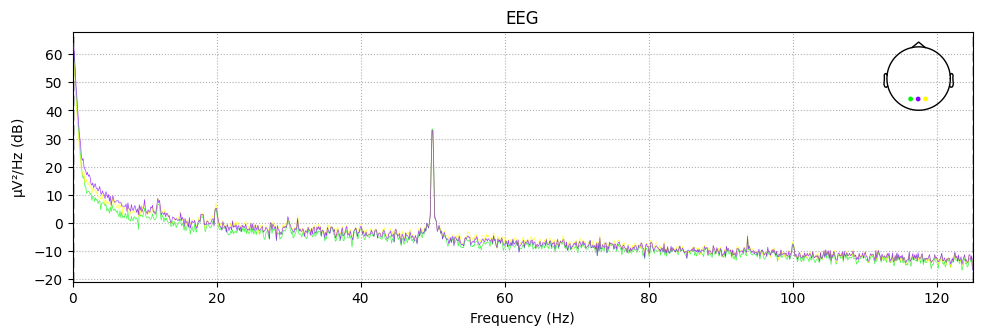

In [9]:
raw = df_to_raw(df)

In [10]:
# events = mne.find_events(raw)
# epochs = mne.Epochs(raw=raw,events=events, baseline=None, tmin=-0.5, tmax=3 - 1/250, reject=None, reject_by_annotation=False)
# data = epochs.get_data()
# print(data.shape)
# np.swapaxes(data, 0,2).shape
# print(data[:,:,:-1])
# data = data.reshape(10, 3, 4, 875)
# print(data.shape)
# data = data.reshape(10, 4, 3, 875)
# print(data.shape)
# data = data.reshape(10, 4, 875, 3)
# print(data.shape)
# print(data[:,:-1,:,:])

In [11]:
# plt.plot(data[0][0])
# plt.plot(data[0][1])
# plt.plot(data[0][2])
# plt.plot(data[0][3])
# plt.show()

Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 77 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 4.00, 77.00 Hz: -6.02, -6.02 dB

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 8.192 (s)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished
c:\Users\Sunsun\.virtualenvs\HybridSpeller-q8UBACmb\lib\site-packages\mne\viz\utils.py:137: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


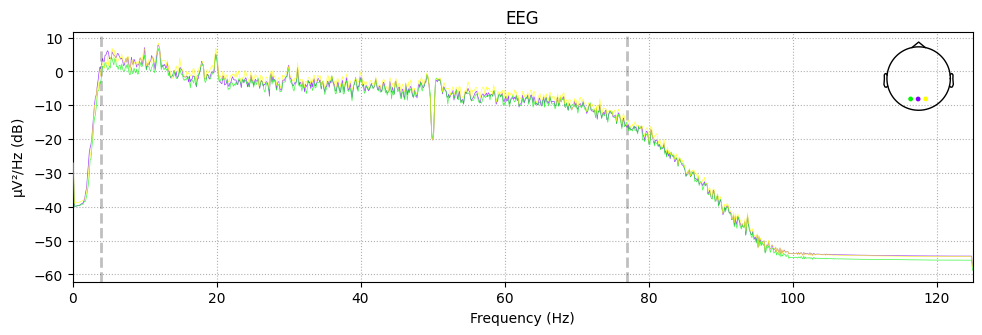

In [12]:
raw.notch_filter(np.arange(50, 125, 50), filter_length='auto', phase='zero') #250/2 based on Nyquist Theorem
#observe that the 50Hz noise is now gone, yay!
raw.filter(4, 77, method='iir')

raw.plot_psd()

In [13]:
# Load raw data
# data_path = mne.datasets.ssvep.data_path()
# data_path = moabb.datasets.Nakanishi2015.data_path(subject = 1)

# bids_fname = (data_path)

# raw = mne.io.read_raw_brainvision(bids_fname, preload=True, verbose=False)
raw.info['line_freq'] = 60.

# Set montage
# montage = mne.channels.make_standard_montage('standard_1020')
# raw.set_montage(montage, verbose=False)

# Set common average reference
raw.set_eeg_reference('average', projection=False, verbose=False)

# Apply bandpass filter
raw.filter(l_freq=0.1, h_freq=None, fir_design='firwin', verbose=False)

# Construct epochs
event_id = {
    '6hz': 1,
    '10hz': 2,
    '15hz': 3
}
# events, _ = mne.events_from_annotations(raw, verbose=False)
events = mne.find_events(raw)
tmin, tmax = 0, 4.  # in s
baseline = None
epochs = mne.Epochs(
    raw, events=events,
    event_id=[event_id['6hz'], event_id['10hz'], event_id['15hz']], tmin=tmin,
    tmax=tmax, baseline=baseline, verbose=False)

30 events found
Event IDs: [1 2 3]


In [14]:
tmin = 0
tmax = 4.
fmin = 1.
fmax = 90.
sfreq = epochs.info['sfreq']

spectrum = epochs.compute_psd(
    'welch',
    n_fft=int(sfreq * (tmax - tmin)),
    n_overlap=0, n_per_seg=None,
    tmin=tmin, tmax=tmax,
    fmin=fmin, fmax=fmax,
    window='boxcar',
    verbose=False)
psds, freqs = spectrum.get_data(return_freqs=True)

In [15]:
def snr_spectrum(psd, noise_n_neighbor_freqs=1, noise_skip_neighbor_freqs=1):
    """Compute SNR spectrum from PSD spectrum using convolution.

    Parameters
    ----------
    psd : ndarray, shape ([n_trials, n_channels,] n_frequency_bins)
        Data object containing PSD values. Works with arrays as produced by
        MNE's PSD functions or channel/trial subsets.
    noise_n_neighbor_freqs : int
        Number of neighboring frequencies used to compute noise level.
        increment by one to add one frequency bin ON BOTH SIDES
    noise_skip_neighbor_freqs : int
        set this >=1 if you want to exclude the immediately neighboring
        frequency bins in noise level calculation

    Returns
    -------
    snr : ndarray, shape ([n_trials, n_channels,] n_frequency_bins)
        Array containing SNR for all epochs, channels, frequency bins.
        NaN for frequencies on the edges, that do not have enough neighbors on
        one side to calculate SNR.
    """
    # Construct a kernel that calculates the mean of the neighboring
    # frequencies
    averaging_kernel = np.concatenate((
        np.ones(noise_n_neighbor_freqs),
        np.zeros(2 * noise_skip_neighbor_freqs + 1),
        np.ones(noise_n_neighbor_freqs)))
    averaging_kernel /= averaging_kernel.sum()

    # Calculate the mean of the neighboring frequencies by convolving with the
    # averaging kernel.
    mean_noise = np.apply_along_axis(
        lambda psd_: np.convolve(psd_, averaging_kernel, mode='valid'),
        axis=-1, arr=psd
    )

    # The mean is not defined on the edges so we will pad it with nas. The
    # padding needs to be done for the last dimension only so we set it to
    # (0, 0) for the other ones.
    edge_width = noise_n_neighbor_freqs + noise_skip_neighbor_freqs
    pad_width = [(0, 0)] * (mean_noise.ndim - 1) + [(edge_width, edge_width)]
    mean_noise = np.pad(
        mean_noise, pad_width=pad_width, constant_values=np.nan
    )

    return psd / mean_noise

In [16]:
snrs = snr_spectrum(psds, noise_n_neighbor_freqs=3,
                    noise_skip_neighbor_freqs=1)

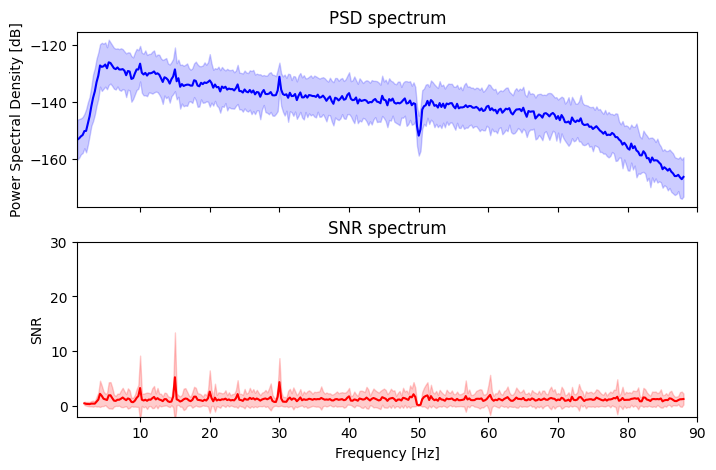

In [17]:
fig, axes = plt.subplots(2, 1, sharex='all', sharey='none', figsize=(8, 5))
freq_range = range(np.where(np.floor(freqs) == 1.)[0][0],
                   np.where(np.ceil(freqs) == fmax - 1)[0][0])

psds_plot = 10 * np.log10(psds)
psds_mean = psds_plot.mean(axis=(0, 1))[freq_range]
psds_std = psds_plot.std(axis=(0, 1))[freq_range]
axes[0].plot(freqs[freq_range], psds_mean, color='b')
axes[0].fill_between(
    freqs[freq_range], psds_mean - psds_std, psds_mean + psds_std,
    color='b', alpha=.2)
axes[0].set(title="PSD spectrum", ylabel='Power Spectral Density [dB]')

# SNR spectrum
snr_mean = snrs.mean(axis=(0, 1))[freq_range]
snr_std = snrs.std(axis=(0, 1))[freq_range]

axes[1].plot(freqs[freq_range], snr_mean, color='r')
axes[1].fill_between(
    freqs[freq_range], snr_mean - snr_std, snr_mean + snr_std,
    color='r', alpha=.2)
axes[1].set(
    title="SNR spectrum", xlabel='Frequency [Hz]',
    ylabel='SNR', ylim=[-2, 30], xlim=[fmin, fmax])
fig

In [18]:
# Define different ROIs
roi_vis = ['Oz', 'O1', 'O2']  # visual roi

# Find corresponding indices using mne.pick_types()
picks_roi_vis = mne.pick_types(epochs.info, eeg=True, stim=False,
                               exclude='bads', selection=roi_vis)

i_trial_6hz = np.where(epochs.events[:, 2] == event_id['6hz'])[0]
i_trial_10hz = np.where(epochs.events[:, 2] == event_id['10hz'])[0]
i_trial_15hz = np.where(epochs.events[:, 2] == event_id['15hz'])[0]

In [19]:
snrs.shape

(30, 3, 357)

In [20]:
picks_roi_vis

array([0, 1, 2])

In [21]:
snrs[:, picks_roi_vis, :].mean(axis=1)

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

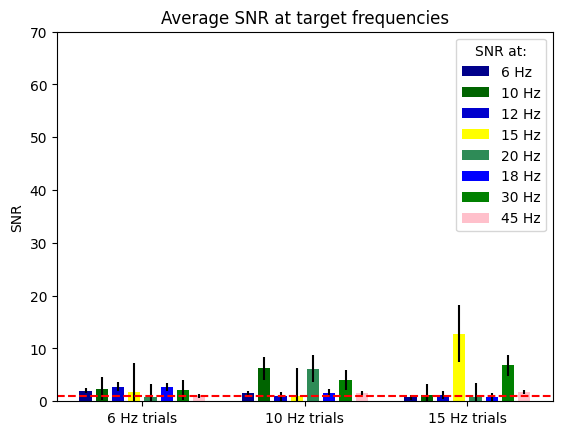

In [22]:
snrs_roi = snrs[:, picks_roi_vis, :].mean(axis=1)

freq_plot = [6, 10, 12, 15, 20, 18, 30, 45]
color_plot = [
    'darkblue', 'darkgreen', 'mediumblue', 'yellow',  'seagreen', 'blue','green', 'pink'
]
xpos_plot = [-7./12, -5. / 12, -3. / 12,  -1. / 12, 1. / 12,  3. / 12,  5. / 12, 7./12]
fig, ax = plt.subplots()
labels = ['6 Hz trials', '10 Hz trials', "15 Hz trials"]
x = np.arange(len(labels))  # the label locations
width = 0.6  # the width of the bars
res = dict()

# loop to plot SNRs at stimulation frequencies and harmonics
for i, f in enumerate(freq_plot):
    # extract snrs
    stim_6hz_tmp = \
        snrs_roi[i_trial_6hz, np.argmin(abs(freqs - f))]
    stim_10hz_tmp = \
        snrs_roi[i_trial_10hz, np.argmin(abs(freqs - f))]
    stim_15hz_tmp = \
        snrs_roi[i_trial_15hz, np.argmin(abs(freqs - f))]
    SNR_tmp = [stim_6hz_tmp.mean(), stim_10hz_tmp.mean(), stim_15hz_tmp.mean()]
    # plot (with std)
    ax.bar(
        x + width * xpos_plot[i], SNR_tmp, width / len(freq_plot),
        yerr=np.std(SNR_tmp),
        label='%i Hz SNR' % f, color=color_plot[i])
    # store results for statistical comparison
    res['stim_6hz_snrs_%ihz' % f] = stim_6hz_tmp
    res['stim_10hz_snrs_%ihz' % f] = stim_10hz_tmp
    res['stim_15hz_snrs_%ihz' % f] = stim_15hz_tmp

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('SNR')
ax.set_title('Average SNR at target frequencies')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(['%i Hz' % f for f in freq_plot], title='SNR at:')
ax.set_ylim([0, 70])
ax.axhline(1, ls='--', c='r')
# fig.show()
fig

In [23]:
X = mne.time_frequency.stft(raw.get_data(), wsize = 4, tstep=2)
print(X.shape)

Number of frequencies: 3
Number of time steps: 16476
(4, 3, 16476)


In [24]:
# csd_fft = mne.time_frequency.csd_fourier(epochs.load_data(), fmin=1, fmax=60, n_jobs=1)

In [25]:
data = epochs.get_data()[:, :-1, :]
print(data.shape)

Using data from preloaded Raw for 30 events and 1001 original time points ...
(30, 3, 1001)


C:\Users\Sunsun\AppData\Local\Temp\ipykernel_8216\2925868329.py:9: UserWarning: Only one segment is calculated since parameter NFFT (=876) >= signal length (=30).
  plt.specgram(data, NFFT=876, Fs=250, noverlap=120, cmap="jet")


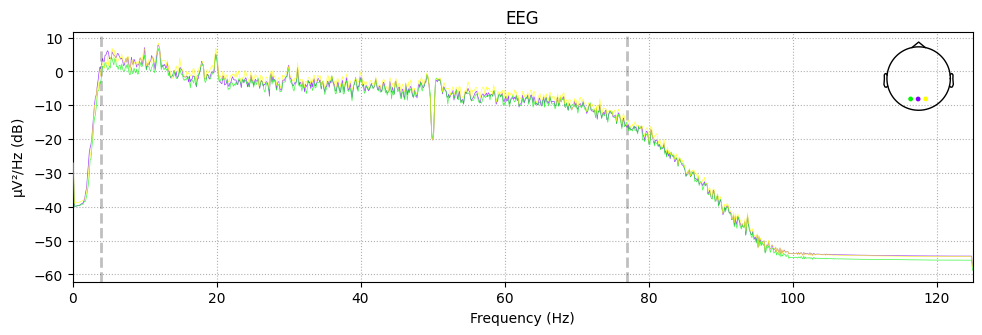

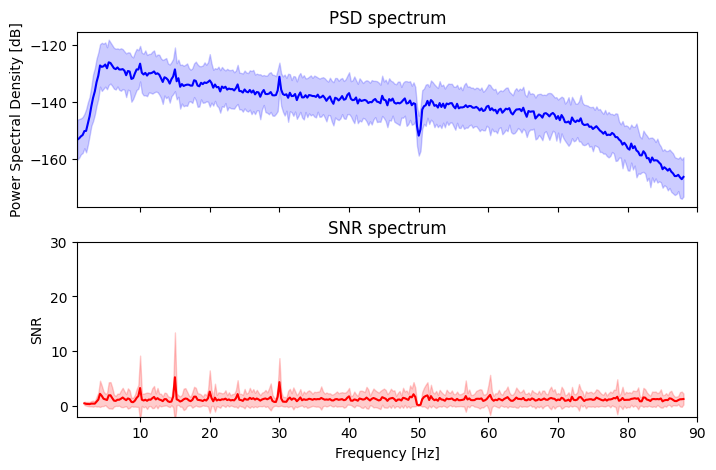

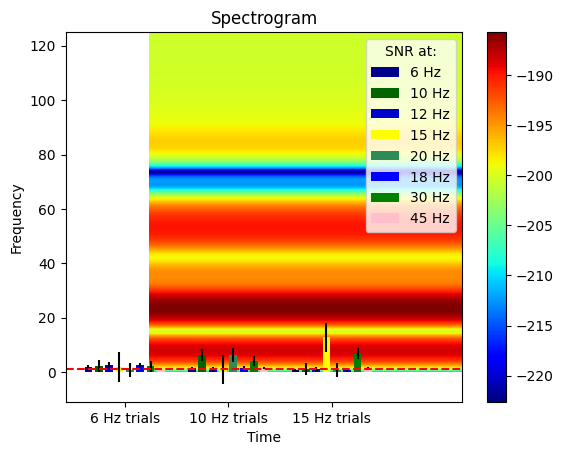

In [26]:
# Importing libraries using import keyword.
import math
import numpy as np
import matplotlib.pyplot as plt
# plt.rcParams["figure.figsize"] = [12,8]
 
# Matplotlib.pyplot.specgram() function to
# generate spectrogram
plt.specgram(data, NFFT=876, Fs=250, noverlap=120, cmap="jet")
 
# Set the title of the plot, xlabel and ylabel
# and display using show() function
plt.title('Spectrogram')
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar()
plt.show()

In [27]:
from mne import time_frequency

In [28]:
data.shape

(30, 3, 1001)

In [29]:
stft_data = []
for i in range(data.shape[0]):
    stft = time_frequency.stft(data[i], wsize=252, verbose=False); 
    stft_data.append(np.expand_dims(stft, axis=0))
stft_data = np.concatenate(stft_data, axis=0)
stft_data.shape

(30, 3, 127, 8)

In [30]:
stft_data.shape

(30, 3, 127, 8)

In [31]:
viz_data = stft_data[0]
print(viz_data.shape)

(3, 127, 8)


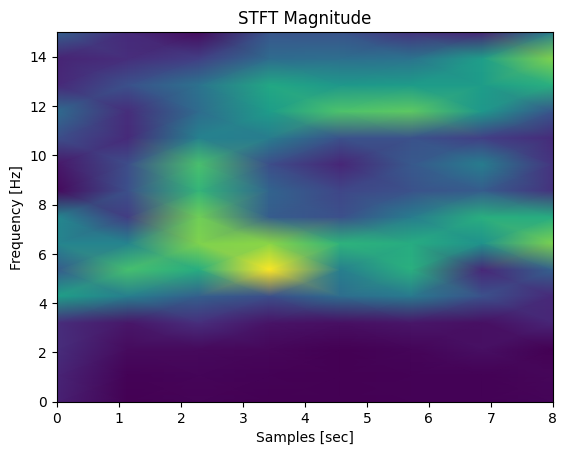

In [32]:
plt.pcolormesh(np.linspace(0,  viz_data.shape[2] , num= viz_data.shape[2]),# x
               np.linspace(0, 15 , num=15),# y
               np.abs(viz_data[0][:15,:]),
               shading='gouraud')
plt.title('STFT Magnitude')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Samples [sec]')
plt.show()

In [33]:
i_trial_6hz

array([ 0,  3,  6,  9, 12, 15, 18, 21, 24, 27], dtype=int64)

In [34]:
picks_roi_vis

array([0, 1, 2])

In [35]:
np.arange(0,X.shape[1]//2,0.5)

array([0. , 0.5])

In [36]:
range(X.shape[0])

range(0, 4)

In [37]:
np.abs(X).shape

(4, 3, 16476)

In [38]:
np.arange(0,(X.shape[1] + 1) //2,0.5).shape

(4,)

In [39]:
len(range(X.shape[0]+1))

5

In [40]:
plt.rcParams["figure.figsize"] = [10,6]

In [48]:
i_trial_6hz

array([ 0,  3,  6,  9, 12, 15, 18, 21, 24, 27], dtype=int64)

In [47]:
stft_data.shape

(30, 3, 127, 8)

(10, 3, 127, 8)
(45, 8)


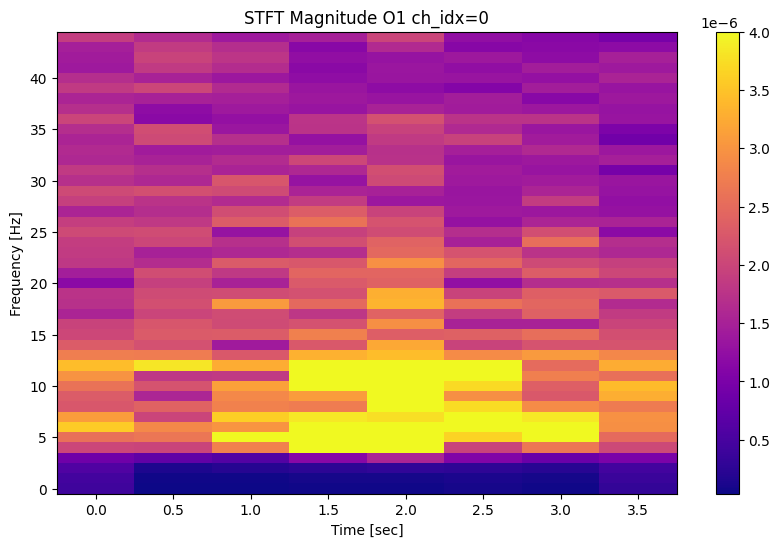

(10, 3, 127, 8)
(45, 8)


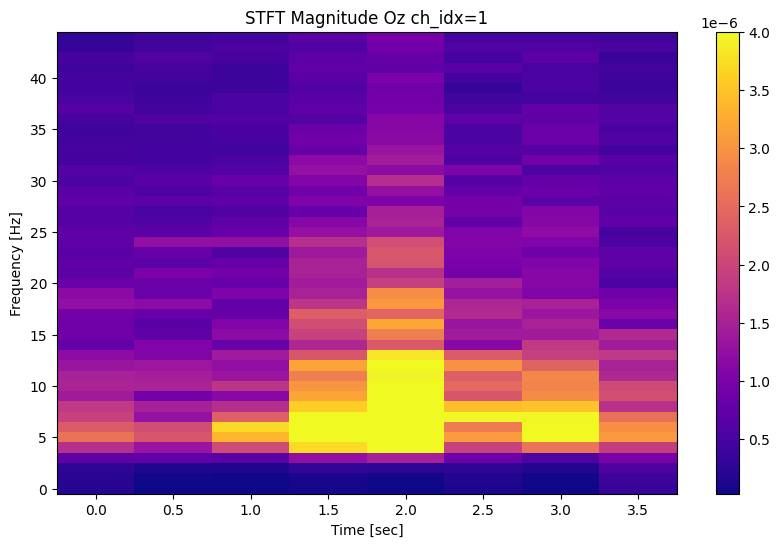

(10, 3, 127, 8)
(45, 8)


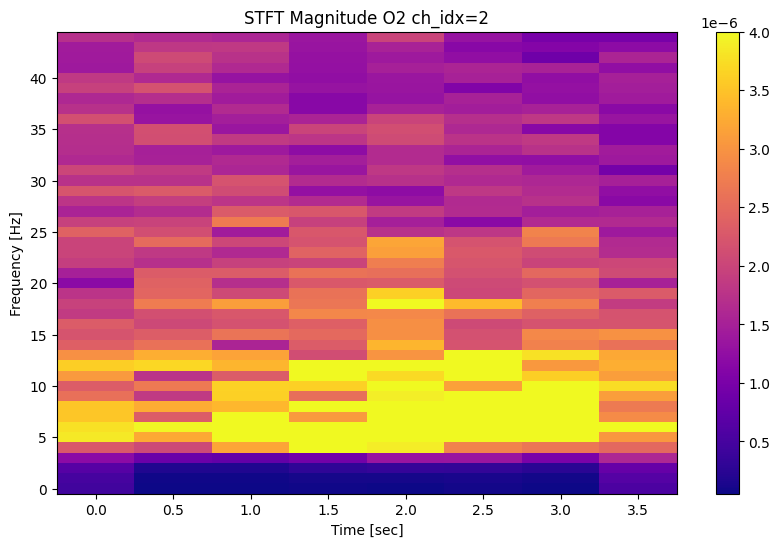

In [59]:
sample_idx = 4

for ch_idx in picks_roi_vis:
    X = stft_data[i_trial_6hz]
    print(X.shape)
    X = abs(X)
    X = X.mean(axis=0)
    X = X[ch_idx]
    X = X[:45,:]
    print(X.shape)

    c = plt.pcolormesh(np.arange(0,(X.shape[1]) //2,0.5), range(X.shape[0]), np.abs(X), cmap='plasma', vmax=4e-6)
    plt.colorbar(c)
    plt.title(f'STFT Magnitude {raw.ch_names[ch_idx]} {ch_idx=}')
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    plt.show()